In [1]:
import numpy as np
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import io, color, transform

import cv2
import numpy as np
import os
import pandas as pd
import re

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

# READ DATA

In [2]:
data = pd.read_csv("dataset_without_hog.csv")

# CHECK CLASS IMBALANCE

In [3]:
class_counts = data['label'].value_counts()
print(class_counts)

label
0    2700
1    2700
2    2700
3    2700
4    2700
Name: count, dtype: int64


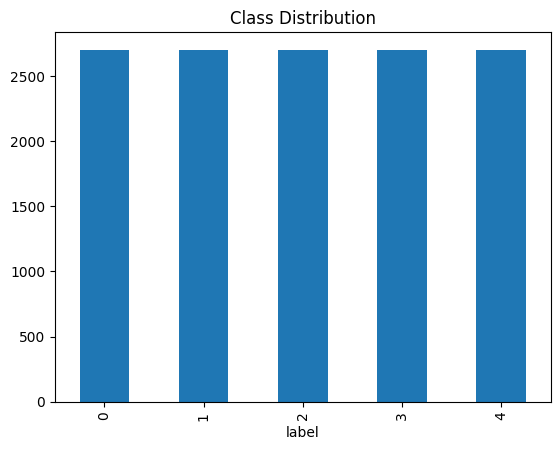

In [4]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cân bằng lớp
class_counts.plot(kind='bar', title='Class Distribution')
plt.show()


In [5]:
total_samples = len(data)
class_ratios = class_counts / total_samples
print(class_ratios)


label
0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: count, dtype: float64


# SPLIT DATA

In [6]:
x = data.drop("label", axis=1)
y = data['label']

In [7]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

In [8]:
# Kiểm tra dữ liệu
X_train[0]

array([17, 17, 17, ..., 25, 28, 23])

In [9]:
X_train[0].shape

(2304,)

# SCALE DATA

In [10]:
# Khởi tạo mô hình MinMaxScaler và fit trên tập huấn luyện
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Sử dụng mô hình đã fit để chuẩn hóa tập kiểm tra
X_test_scaled = scaler.transform(X_test)

# TRAIN

In [11]:
from sklearn.svm import SVC
# Huấn luyện mô hình SVM với các tham số cụ thể
svm_model = SVC(C=0.1, gamma=0.1, kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train)

# Dự đoán nhãn trên tập kiểm tra
y_pred = svm_model.predict(X_test_scaled)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5669135802469136


# EVALUATE

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tabulate import tabulate

# Assume y_test and y_pred are already defined

# Calculate precision, recall, and f1-score for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

# Calculate overall precision, recall, and f1-score
overall_precision = precision.mean()
overall_recall = recall.mean()
overall_f1 = f1.mean()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Create the table
table = []
for i in range(len(class_names)):
    table.append([class_names[i], f"{precision[i]:.4f}", f"{recall[i]:.4f}", f"{f1[i]:.4f}"])
table.append(["Overall", f"{overall_precision:.4f}", f"{overall_recall:.4f}", f"{overall_f1:.4f}"])

# Print the table
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score"], tablefmt="grid"))

# Print accuracy
print(f"\nAccuracy: {accuracy:.4f}")

+---------+-------------+----------+------------+
| Class   |   Precision |   Recall |   F1-Score |
+=========+=============+==========+============+
| Angry   |      0.465  |   0.4572 |     0.4611 |
+---------+-------------+----------+------------+
| Fear    |      0.4922 |   0.4733 |     0.4826 |
+---------+-------------+----------+------------+
| Happy   |      0.7467 |   0.7803 |     0.7631 |
+---------+-------------+----------+------------+
| Neutral |      0.6877 |   0.7305 |     0.7085 |
+---------+-------------+----------+------------+
| Sad     |      0.4143 |   0.3925 |     0.4031 |
+---------+-------------+----------+------------+
| Overall |      0.5612 |   0.5667 |     0.5637 |
+---------+-------------+----------+------------+

Accuracy: 0.5669


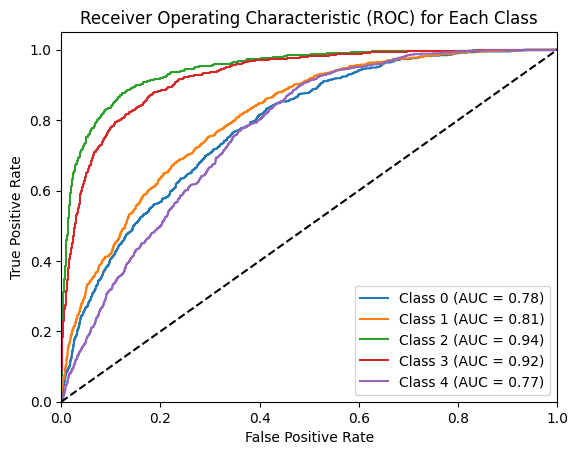

In [13]:
# Import necessary libraries
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get predicted probabilities for each class
y_prob = svm_model.predict_proba(X_test_scaled)

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Each Class')
plt.legend(loc="lower right")
plt.show()


# SAVE MODEL

In [14]:
import pickle

with open('svm_model_without_hog.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [15]:
from joblib import dump
dump(svm_model, 'svm_model_without_hog.h5')

['svm_model_without_hog.h5']

# Tune

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# Thiết lập các giá trị thử nghiệm cho C, kernel và gamma
param_grid = {'C': [0.1, 1, 10, 100, 10000],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.1, 0.5, 5, 50]}

# Tạo mô hình SVM
svm_model = SVC()

# Sử dụng GridSearchCV để tìm kiếm qua lưới tham số
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best Parameters:", grid_search.best_params_)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")